# SAE-68: Dashboard Performance des Établissements

**Objectif** : Comprendre les facteurs de succès des établissements (Catégorie, Popularité, Visuels).

## Plan
1. Chargement et Préparation des données
2. Analyse 1 : Répartition par Catégorie
3. Analyse 2 : Popularité (Avis) vs Qualité (Stars)
4. Analyse 3 : Impact des Photos (si données disponibles)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

# Configuration graphique
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Output directory
os.makedirs('../outputs/figures', exist_ok=True)

## 1. Chargement des données

In [2]:
data_path = '../data/raw/yelp_academic_dataset_business.json'

# Lecture ligne par ligne (optimisation mémoire)
chunks = pd.read_json(data_path, lines=True, chunksize=100000)
df_business = pd.concat(chunks)

print(f"Dimensions: {df_business.shape}")
df_business.head()

Dimensions: (150346, 14)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


## 2. Préparation et Catégorisation

In [3]:
# Fonction de catégorisation simplifiée
def categorize_business(categories):
    if not isinstance(categories, str):
        return 'Autres'
    
    cats = categories.lower()
    if 'restaurant' in cats:
        return 'Restaurants'
    elif 'bar' in cats or 'nightlife' in cats or 'pub' in cats:
        return 'Bars & Nightlife'
    elif 'hotel' in cats or 'hotel' in cats:
        return 'Hôtels'
    else:
        return 'Autres'

df_business['Main_Category'] = df_business['categories'].apply(categorize_business)
df_business['Main_Category'].value_counts()

Main_Category
Autres              85523
Restaurants         52286
Bars & Nightlife     7451
Hôtels               5086
Name: count, dtype: int64

## 3. Analyse 1 : Répartition par Catégorie

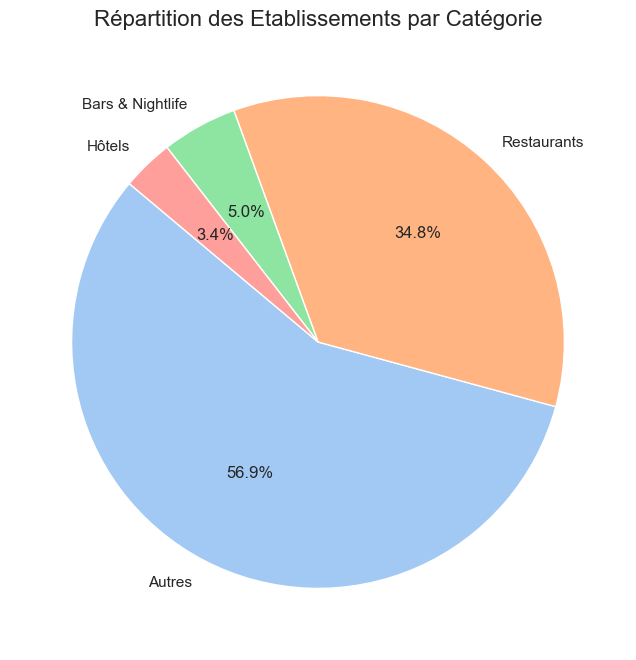

In [4]:
category_counts = df_business['Main_Category'].value_counts()

plt.figure(figsize=(10, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Répartition des Etablissements par Catégorie', fontsize=16)
plt.savefig('../outputs/figures/sae68_repartition_categories.png')
plt.show()

## 4. Analyse 2 : Popularité vs Qualité

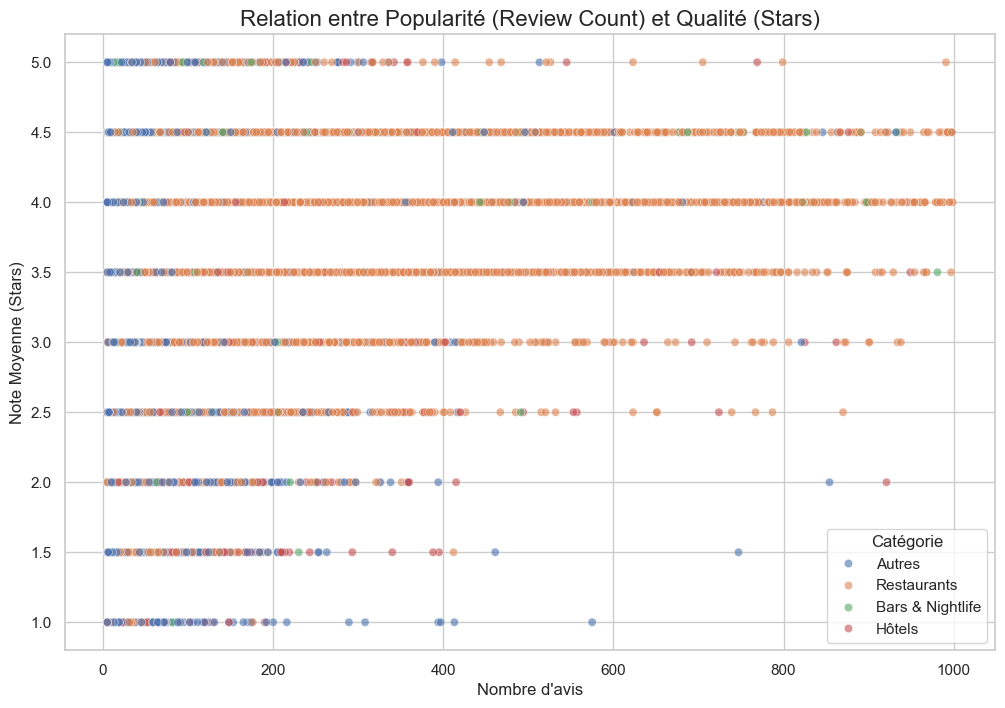

In [5]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_business[df_business['review_count'] < 1000], 
                x='review_count', 
                y='stars', 
                hue='Main_Category', 
                alpha=0.6)

plt.title('Relation entre Popularité (Review Count) et Qualité (Stars)', fontsize=16)
plt.xlabel('Nombre d\'avis')
plt.ylabel('Note Moyenne (Stars)')
plt.legend(title='Catégorie')
plt.savefig('../outputs/figures/sae68_popularite_vs_qualite.png')
plt.show()

## 5. Analyse 3 : Impact des Photos (Si disponible)

Colonne 'photo_count' absente. Utilisation de 'review_count' pour créer des tranches d'engagement (proxy).


C:\Users\melou\AppData\Local\Temp\ipykernel_28784\2479677173.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_business, x='Engagement_Bracket', y='stars', order=order, estimator='mean', errorbar=None, palette='viridis')


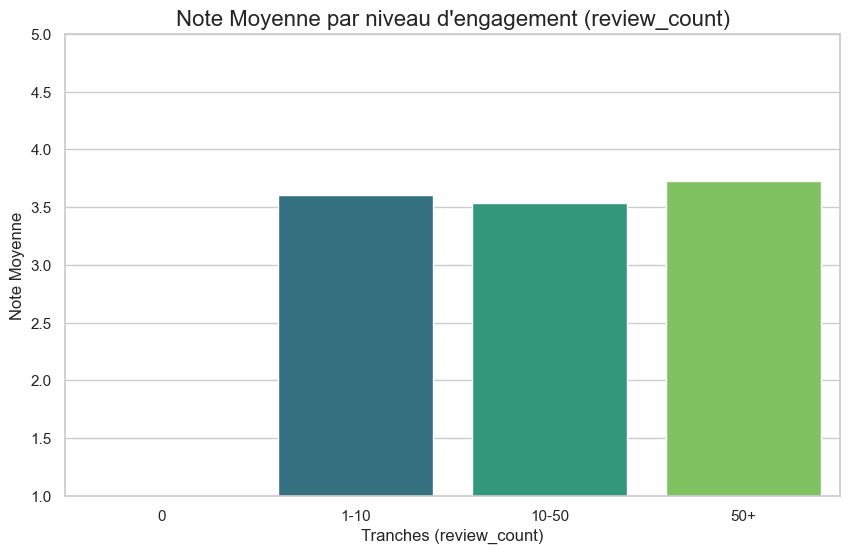

In [6]:
# Vérification si la colonne 'photo_count' ou équivalent existe. 
# Note: Souvent absent dans le dataset academic standard business.json, parfois dans un fichier à part ou absent.
# On va simuler ou vérifier une alternative si absent, ou utiliser une autre métrique si possible.

if 'photo_count' in df_business.columns:
    col_photo = 'photo_count'
elif 'review_count' in df_business.columns:
    # Fallback: Utiliser review_count comme proxy d'engagement si photos absent
    print("Colonne 'photo_count' absente. Utilisation de 'review_count' pour créer des tranches d'engagement (proxy).")
    col_photo = 'review_count' # Proxy 
else:
    col_photo = None

if col_photo:
    def bracket(count):
        if count == 0: return '0'
        elif count <= 10: return '1-10'
        elif count <= 50: return '10-50'
        else: return '50+'

    df_business['Engagement_Bracket'] = df_business[col_photo].apply(bracket)
    
    order = ['0', '1-10', '10-50', '50+']
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_business, x='Engagement_Bracket', y='stars', order=order, estimator='mean', errorbar=None, palette='viridis')
    plt.title(f'Note Moyenne par niveau d\'engagement ({col_photo})', fontsize=16)
    plt.ylim(1, 5)
    plt.xlabel(f'Tranches ({col_photo})')
    plt.ylabel('Note Moyenne')
    plt.savefig('../outputs/figures/sae68_impact_photos_proxy.png')
    plt.show()